# [과제] COVID 데이터 예측

SHAPE 맞추는 데에 의의를 두자.

- 데이터: Kaggle Novel-Covid19
- CNN, LSTM 모델을 `병렬`, `직렬`로 각각 다르게 구성한 hybrid network를 2개 구성하고, 그 결과를 비교해 보자.
    - +) 추가: 직렬 순서 CNN-LSTM도 해보기



> 주의
* 변수명 계속 그대로 사용했음. `py` 파일로 분리해서 다시 정리할 것.
* shape : 다른 사람들이 shape 맞춘 방법도 함께 확인.
* 직렬 모델 구성 시 `TimeDistributed` 사용하면 안 되는 이유.
* 각 모델 노드 구성 다 똑같지는 않다.


## _0_. 모듈 및 경로

In [1]:
# module import
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional # LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D # CNN
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Reshape # 모델 네트워크 구성
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"

## _1_. 데이터 준비

* 전처리
    - 날짜별 그룹핑
    - 누적합 해제
    - 표준화
* 전처리된 원본 보존

In [30]:
# 데이터 로드
df_raw = pd.read_csv(f"{data_path}/covid_19_data.csv")
df_raw.head(30)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,6,01/22/2020,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,7,01/22/2020,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,8,01/22/2020,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,9,01/22/2020,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,10,01/22/2020,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [ ]:
# 전처리
df_raw = df_raw.groupby(by='ObservationDate').sum()
df_raw = (df_raw - df_raw.shift(1)).drop(columns=['SNo'], axis=1).dropna()
display(df_raw)

# 표준화
scaler = StandardScaler()
train_data = scaler.fit_transform(df_raw) # np.array 형태
print(train_data[:10])

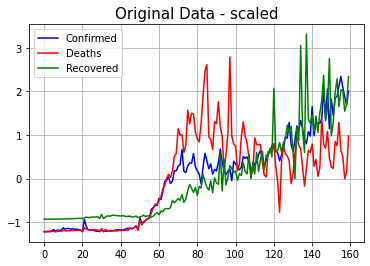

In [5]:
# 원래 데이터 확인
plt.plot(train_data[:, 0], label='Confirmed', color='blue')
plt.plot(train_data[:, 1], label='Deaths', color='red')
plt.plot(train_data[:, 2], label='Recovered', color='green')
plt.title('Original Data - scaled', size=15)
plt.legend()
plt.grid()
plt.show()

## _2_. 병렬 모델

* data -> LSTM
* data -> CNN
* LSTM + CNN -> FFN
* FFN -> **output**

### 2.1. LSTM 네트워크 구성

- 입력 데이터 형태 변환 시 `a`, `b`를 다르게 해줘야 하는 이유를 알았다!
- 내 방법처럼 하려면, 인덱싱이 `i+step`으로 들어 가야 한다.


> 오류 기록

```
def createData(X_data, step, feature):
    m = np.arange(len(X_data) - step)
    
    x, y = [], []
    for i in m:
        a = X_data[i:i+step]
        b = X_data[i+1+step] # a 다음에 나오는 데이터
        x.append(a)
        y.append(b)
    
    X = np.reshape(np.array(x), (len(m), step, feature))
    Y = np.reshape(np.array(y), (len(m), feature))

    return X, Y

 8         b = X_data[i+1+step] # a 다음에 나오는 데이터
      9         x.append(a)
     10         y.append(b)

IndexError: index 160 is out of bounds for axis 0 with size 160
```


In [6]:
# LSTM 파라미터 설정
n_step = int(input('시계열 스텝 설정: '))
n_features = int(input('피쳐 수 설정: '))

시계열 스텝 설정: 20
피쳐 수 설정: 3


In [7]:
def createData(X_data, step, feature):
    m = np.arange(len(X_data) - step)
    
    x, y = [], []
    for i in m:
        a = X_data[i:i+step]
        b = X_data[i+step] # a 다음에 나오는 데이터
        x.append(a)
        y.append(b)
    
    X = np.reshape(np.array(x), (len(m), step, feature))
    Y = np.reshape(np.array(y), (len(m), feature))

    return X, Y

In [8]:
X_train_lstm, y_train = createData(train_data, n_step, n_features)
print(f"LSTM Train: {X_train_lstm.shape}, LSTM label: {y_train.shape}")

LSTM Train: (140, 20, 3), LSTM label: (140, 3)


In [9]:
# 모델 네트워크 구성
X_input_lstm = Input(batch_shape=(None, n_step, n_features))
X_lstm = Bidirectional(LSTM(128, return_sequences=True), merge_mode='concat')(X_input_lstm)
X_lstm = Flatten()(X_lstm)
X_dense_lstm = Dense(64)(X_lstm)

# 모델 구조 확인
model_lstm = Model(X_input_lstm, X_dense_lstm)
print(f"========= (병렬) LSTM 모델 구조 확인 =========")
print(model_lstm.summary())

========= (병렬) LSTM 모델 구조 확인 =========
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 3)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           135168    
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                327744    
Total params: 462,912
Trainable params: 462,912
Non-trainable params: 0
_________________________________________________________________
None


### 2.2. CNN 네트워크 구성
* 입력 데이터에 channel 축 추가

In [10]:
# 입력 데이터 형태 변환
X_train_cnn = X_train_lstm[:, :, :, np.newaxis]
print(f"CNN Train: {X_train_cnn.shape}")

CNN Train: (140, 20, 3, 1)


In [11]:
# CNN 네트워크 파라미터
k_size = int(input('컨볼루션 필터 사이즈 설정: '))
p_size = int(input('풀링 필터 사이즈 설정: '))

컨볼루션 필터 사이즈 설정: 4
풀링 필터 사이즈 설정: 2


In [12]:
# CNN 네트워크 구성
X_input_cnn = Input(batch_shape=(None, n_step, n_features, 1)) # channel: 1
X_conv = Conv2D(filters=30, kernel_size=(k_size, k_size), strides=1, padding='same', activation='relu')(X_input_cnn)
X_pool = MaxPooling2D(pool_size=(p_size, p_size), strides=1, padding='valid')(X_conv)
X_flat = Flatten()(X_pool)
X_dense_cnn = Dense(64)(X_flat)

# 모델 구조 확인
model_cnn = Model(X_input_cnn, X_dense_cnn)
print(f"========= (병렬) CNN 모델 구조 확인 =========")
print(model_cnn.summary())

========= (병렬) CNN 모델 구조 확인 =========
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 3, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 3, 30)         510       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 2, 30)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1140)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                73024     
Total params: 73,534
Trainable params: 73,534
Non-trainable params: 0
_________________________________________________________________
None


### 2.3. 네트워크 결합

* 시계열: linear, mse

In [13]:
# latent feature 결합
X_concat = Concatenate()([X_dense_lstm, X_dense_cnn])
y_output = Dense(n_features, activation='linear')(X_concat)

# 모델 구성
model_parallel = Model([X_input_lstm, X_input_cnn], y_output)
print(f"========= (병렬) 전체 모델 구조 확인 =========")
print(model_parallel.summary())

========= (병렬) 전체 모델 구조 확인 =========
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20, 3, 1)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 20, 3)]      0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 3, 30)    510         input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 256)      135168      input_1[0][0]                    
_______________________________________________________

In [14]:
# 모델 컴파일
model_parallel.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

### 2.4. 모델 학습

In [15]:
# 학습
EPOCHS = int(input('학습 횟수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))

es = EarlyStopping(monitor='loss', patience=10, verbose=1)
hist = model_parallel.fit([X_train_lstm, X_train_cnn], y_train,
                          batch_size=BATCH,
                          epochs=EPOCHS,
                          callbacks=[es])

학습 횟수 설정: 1000
배치 사이즈 설정: 300
Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1175
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9102
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6486
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2279
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3169
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4360
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3591
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2154
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1441
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1708
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2252
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2308
Epoch 13/1000
1/1 [

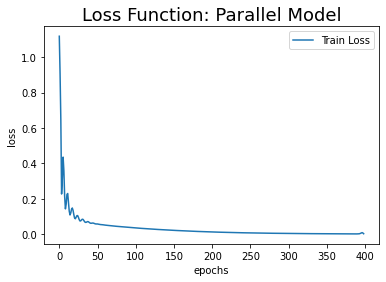

In [16]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Function: Parallel Model', size=18)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### 2.5. 예측 및 결과 확인

In [17]:
# 예측
n_futures = int(input('예측 기간 설정: '))
X_test = np.copy(train_data)
X_estimates = [X_test[-1]] # 예측값 저장할 배열

for _ in range(n_futures):
    x_lstm = X_test[-n_step:].reshape(-1, n_step, n_features)
    x_cnn = x_lstm[:, :, :, np.newaxis] # 채널 축 추가

    y_pred = model_parallel.predict([x_lstm, x_cnn])[0] # 예측값

    X_estimates.append(y_pred) # 예측값 배열에 저장

    # X_test = np.insert(X_test, len(X_test), y_pred).reshape(-1, n_features) # reshape 필요함
    X_test = np.insert(X_test, len(X_test), y_pred, axis=0) # 이렇게 해야 예측 제대로 됨.

예측 기간 설정: 30


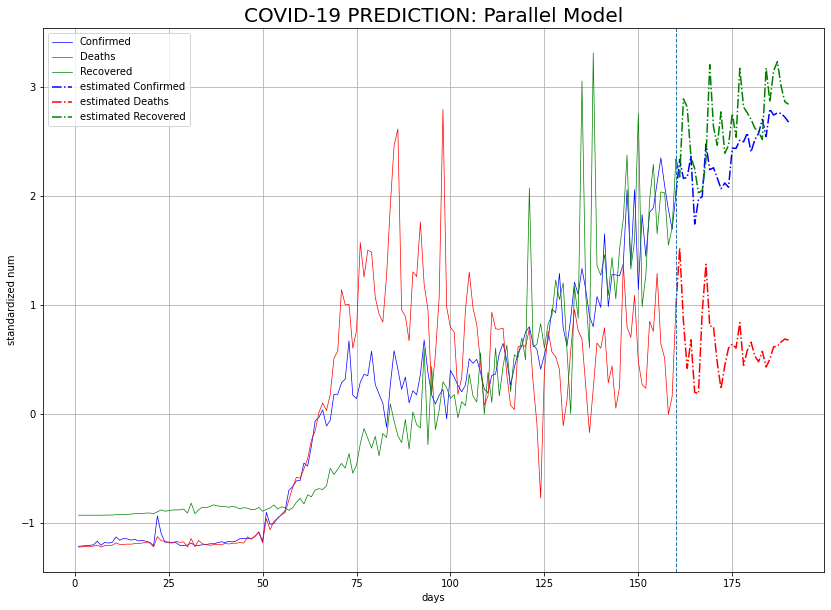

In [18]:
# 데이터 시각화
last_data = X_test[:len(train_data)]
estimated_data = np.array(X_estimates)

ax1 = np.arange(1, len(train_data)+1)
ax2 = np.arange(len(train_data), len(last_data)+len(estimated_data))

plt.figure(figsize=(14, 10))
plt.plot(ax1, last_data[:, 0], label='Confirmed', linewidth=0.7, color='blue')
plt.plot(ax1, last_data[:, 1], label='Deaths', linewidth=0.7, color='red')
plt.plot(ax1, last_data[:, 2], label='Recovered', linewidth=0.7, color='green')
plt.plot(ax2, estimated_data[:, 0], label='estimated Confirmed', linestyle='dashdot', color='blue')
plt.plot(ax2, estimated_data[:, 1], label='estimated Deaths', linestyle='dashdot', color='red')
plt.plot(ax2, estimated_data[:, 2], label='estimated Recovered', linestyle='dashdot', color='green')

plt.axvline(ax1[-1], linestyle='dashed', linewidth=1)

plt.grid()
plt.legend()
plt.xlabel('days')
plt.ylabel('standardized num')
plt.title('COVID-19 PREDICTION: Parallel Model', size=20)

plt.show()

## _3_. 직렬 모델

### 3.1. LSTM -> CNN

* 오류 : 직렬로 맞춘 다음에 바로 병렬로 넣어 줘야 하니까, LSTM -> Reshape -> CNN 갈 때 배수 맞춰서 넣어 줘야 한다. 맞는지는 모르겠으나 일단 그렇게 이해한다.

```
X_input_s = Input(batch_shape=(None, n_step, n_features)) # (140, 20, 3) 들어올 것
X_lstm_s = Bidirectional(LSTM(128), merge_mode='concat')(X_input_s) # (None, 256)
X_reshape_s = Reshape((n_step, n_features, 1))(X_lstm_s) # (None, 20, 3, 1)
X_conv_s = Conv2D(filters=30, kernel_size=(k_size, k_size), strides=1, padding='same', activation='relu')(X_reshape_s) # (None, 20, 3, 30)
X_pool_s = MaxPooling2D(pool_size=(p_size, p_size), strides=1, padding='valid')(X_conv_s)
X_flat_s = Flatten()(X_pool_s)
X_dense_s = Dense(64)(X_flat_s)
y_output_s = Dense(n_features, activation='linear')(X_dense_s)
```

```
========= (직렬) 전체 모델 구조 확인 =========
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_19 (InputLayer)        [(None, 20, 3)]           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 256)               135168    
_________________________________________________________________
reshape_12 (Reshape)         (None, 20, 3, 1)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 3, 30)         510       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 2, 30)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1140)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                73024     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
=================================================================
Total params: 208,897
Trainable params: 208,897
Non-trainable params: 0
_________________________________________________________________
None
```

```
InvalidArgumentError:  Input to reshape is a tensor with 35840 values, but the requested shape has 8400
	 [[node model_6/reshape_12/Reshape (defined at <ipython-input-132-a76351a6c48a>:6) ]] [Op:__inference_train_function_43525]

Function call stack:
train_function
```

In [19]:
X_input_s2 = Input(batch_shape=(None, n_step, n_features, 1)) # 채널 축 추가: (None, 20, 3, 1) = 8400개.
X_conv_s2 = Conv2D(filters=30, kernel_size=(10, 1), strides=2, padding='valid', activation='relu')(X_input_s2) 
X_pool_s2 = MaxPooling2D(pool_size=(3, 1), strides=2, padding='valid')(X_conv_s2) 
X_flat_s2 = Flatten()(X_pool_s2) # (None, 8400)
X_reshape_s2 = Reshape((n_step, n_features))(X_flat_s2) # (None, 20, 3): LSTM 입력 형태 = 8400개로 맞춰져야 함.
X_lstm_s2 = Bidirectional(LSTM(30, return_sequences=True), merge_mode='concat')(X_reshape_s2)
X_dense_s2 = Dense(64)(X_lstm_s2)
y_output_s2 = Dense(n_features, activation='linear')(X_dense_s2)

In [20]:
# 모델 네트워크 구성
X_input_s = Input(batch_shape=(None, n_step, n_features))
# _lstm_s =  Bidirectional(LSTM(30), merge_mode='concat')(X_input_s) # 60
X_lstm_s = Bidirectional(LSTM(30, return_sequences=True), merge_mode='concat')(X_input_s) # 1200
X_lstm_s = Flatten()(X_lstm_s)
X_lstm_s = Dense(n_step * n_features)(X_lstm_s) # 맞는 건지 모르겠다! 돌아가긴 한다
X_reshape_s = Reshape((n_step, n_features, 1))(X_lstm_s) # shape 맞추려고
X_conv_s = Conv2D(filters=30, kernel_size=(k_size, k_size), strides=1, padding='same', activation='relu')(X_reshape_s)
X_pool_s = MaxPooling2D(pool_size=(p_size, p_size), strides=1, padding='valid')(X_conv_s)
X_flat_s = Flatten()(X_pool_s)
X_dense_s = Dense(64)(X_flat_s)
y_output_s = Dense(n_features, activation='linear')(X_dense_s)

# 모델 구성
model_serial = Model(X_input_s, y_output_s)
print(f"========= (직렬 1) 전체 모델 구조 확인 =========")
print(model_serial.summary())

# 모델 컴파일
model_serial.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

========= (직렬 1) 전체 모델 구조 확인 =========
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 3)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 60)            8160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 60)                72060     
_________________________________________________________________
reshape_1 (Reshape)          (None, 20, 3, 1)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 3, 30)         510       
_________________________________________________________________
max_pooling2d_2 (Max

In [21]:
# 학습
es = EarlyStopping(monitor='loss', patience=10, verbose=1)
hist = model_serial.fit(X_train_lstm, y_train,
                        batch_size=BATCH,
                        epochs=EPOCHS,
                        callbacks=[es])

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9887
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7065
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4670
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2692
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2272
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2872
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2643
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1900
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1539
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1561
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1668
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1670
Epoch 13/1000
1/1 [==============================

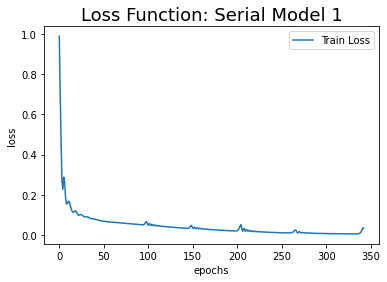

In [22]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Function: Serial Model 1', size=18)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
# 예측
X_test_s = np.copy(train_data)
X_estimates_s = [X_test_s[-1]] # 예측값 저장

for _ in range(n_futures):
    x = X_test_s[-n_step:].reshape(-1, n_step, n_features)
    y_pred = model_serial.predict(x)[0] # 예측값
    X_estimates_s.append(y_pred) # 예측값 배열에 저장
    X_test_s = np.insert(X_test_s, len(X_test_s), y_pred, axis=0) 

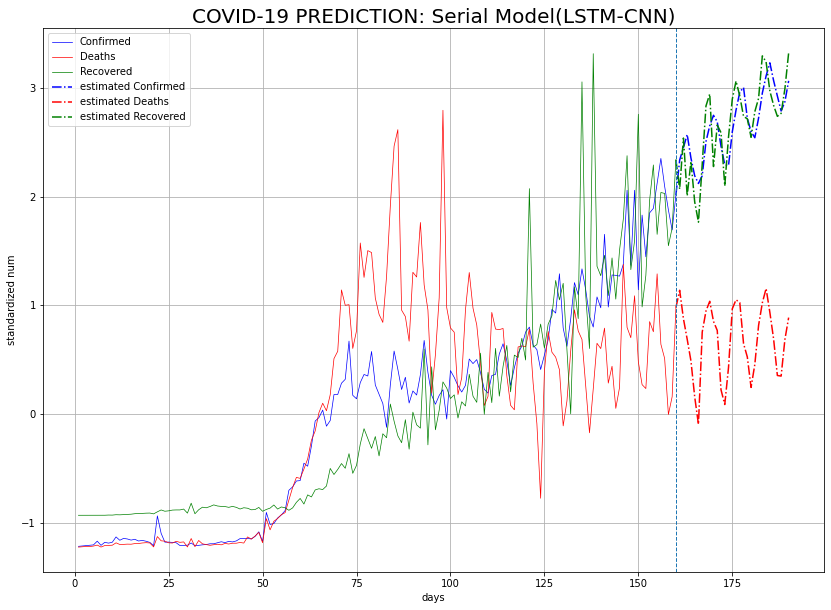

In [24]:
# 데이터 시각화
last_data = X_test_s[:len(train_data)]
estimated_data = np.array(X_estimates_s)

ax1 = np.arange(1, len(train_data)+1)
ax2 = np.arange(len(train_data), len(last_data)+len(estimated_data))

plt.figure(figsize=(14, 10))
plt.plot(ax1, last_data[:, 0], label='Confirmed', linewidth=0.7, color='blue')
plt.plot(ax1, last_data[:, 1], label='Deaths', linewidth=0.7, color='red')
plt.plot(ax1, last_data[:, 2], label='Recovered', linewidth=0.7, color='green')
plt.plot(ax2, estimated_data[:, 0], label='estimated Confirmed', linestyle='dashdot', color='blue')
plt.plot(ax2, estimated_data[:, 1], label='estimated Deaths', linestyle='dashdot', color='red')
plt.plot(ax2, estimated_data[:, 2], label='estimated Recovered', linestyle='dashdot', color='green')

plt.axvline(ax1[-1], linestyle='dashed', linewidth=1)

plt.grid()
plt.legend()
plt.xlabel('days')
plt.ylabel('standardized num')
plt.title('COVID-19 PREDICTION: Serial Model(LSTM-CNN)', size=20)

plt.show()

### 3.2. CNN -> LSTM



#### 오류 1

```
X_input_s2 = Input(batch_shape=(None, n_step, n_features, 1)) # 채널 축 추가: (None, 20, 3, 1)
X_conv_s2 = Conv2D(filters=30, kernel_size=(k_size, k_size), strides=1, padding='same', activation='relu')(X_input_s2) # (None, 20, 3, 60) : 3600
X_pool_s2 = MaxPooling2D(pool_size=(p_size, p_size), strides=1, padding='same')(X_conv_s2) # (None, 10, 1, 60)
X_flat_s2 = Flatten()(X_pool_s2) # (None, 8400)
X_reshape_s2 = Reshape((n_step, n_features))(X_flat_s2) # (None, 20, 3): LSTM 입력 형태
X_lstm_s2 = Bidirectional(LSTM(30), merge_mode='concat')(X_reshape_s2)
X_dense_s2 = Dense(64)(X_lstm_s2)
y_output_s2 = Dense(n_features, activation='linear')(X_dense_s2)
```

```
========= (직렬 2) 전체 모델 구조 확인 =========
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_63 (InputLayer)        [(None, 20, 3, 1)]        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 20, 3, 30)         510       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 20, 3, 30)         0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 1800)              0         
_________________________________________________________________
reshape_27 (Reshape)         (None, 20, 3)             0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 60)                8160      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                3904      
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 195       
=================================================================
Total params: 12,769
Trainable params: 12,769
Non-trainable params: 0
_________________________________________________________________
None
```

```
Input to reshape is a tensor with 252000 values, but the requested shape has 8400
	 [[node model_14/reshape_27/Reshape (defined at <ipython-input-276-12a4be814266>:6) ]] [Op:__inference_train_function_89447]
```


* 252000 / 8400 

컨볼루션, 거쳐서 결과적으로는(내가 준 옵션이 그러하니까 same, same 필터 수 30개 그대로 유지되어서 나온다.) 필터 수를 유지하고 싶으면 kernel_size, pool_size로 어떻게든 조정해야!

* LSTM = n_step * n_feature로 들어오니까 내가 설정한 바에 의하면 8400 나와야 한다. CNN에서 8400 / 140 = 60으로 들어오도록 설정해야 한다!

In [25]:
# 모델 네트워크 구성
X_input_s2 = Input(batch_shape=(None, n_step, n_features, 1)) # 채널 축 추가: (None, 20, 3, 1) = 8400개.
X_conv_s2 = Conv2D(filters=30, kernel_size=(10, 1), strides=2, padding='valid', activation='relu')(X_input_s2) 
X_pool_s2 = MaxPooling2D(pool_size=(3, 1), strides=2, padding='valid')(X_conv_s2) 
X_flat_s2 = Flatten()(X_pool_s2) # (None, 8400)
X_reshape_s2 = Reshape((n_step, n_features))(X_flat_s2) # (None, 20, 3): LSTM 입력 형태 = 8400개로 맞춰져야 함.
X_lstm_s2 = Bidirectional(LSTM(30, return_sequences=True), merge_mode='concat')(X_reshape_s2)
X_lstm_s2 = Flatten()(X_lstm_s2)
X_dense_s2 = Dense(64)(X_lstm_s2)
y_output_s2 = Dense(n_features, activation='linear')(X_dense_s2)

# 모델 구성
model_serial2 = Model(X_input_s2, y_output_s2)
print(f"========= (직렬 2) 전체 모델 구조 확인 =========")
print(model_serial2.summary())

# 모델 컴파일
model_serial2.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

========= (직렬 2) 전체 모델 구조 확인 =========
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 3, 1)]        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 2, 30)          330       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 1, 30)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 60)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 20, 3)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 60)            8160      
_________________________________________________________________
flatten_6 (Flatten) 

In [26]:
# 학습
es = EarlyStopping(monitor='loss', patience=10, verbose=1)
hist = model_serial2.fit(X_train_cnn, y_train,
                         batch_size=BATCH,
                         epochs=EPOCHS,
                         callbacks=[es])

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9650
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.9115
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8592
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.8002
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7345
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6631
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5867
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5068
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.4265
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3515
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2883
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2462
Epoch 13/1000
1/1 [==============================

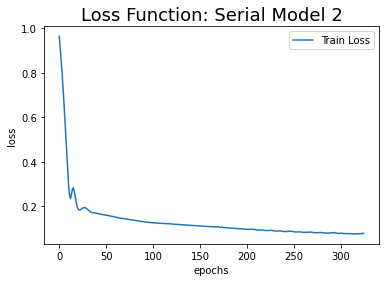

In [27]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Function: Serial Model 2', size=18)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [28]:
# 예측
X_test_s2 = np.copy(train_data)
X_estimates_s2 = [X_test_s2[-1]] # 예측값 저장

for _ in range(n_futures):
    x = X_test_s2[-n_step:].reshape(-1, n_step, n_features)
    y_pred = model_serial2.predict(x)[0] # 예측값
    X_estimates_s2.append(y_pred) # 예측값 배열에 저장
    X_test_s2 = np.insert(X_test_s2, len(X_test_s2), y_pred, axis=0) # 이렇게 해야 예측 제대로 됨.

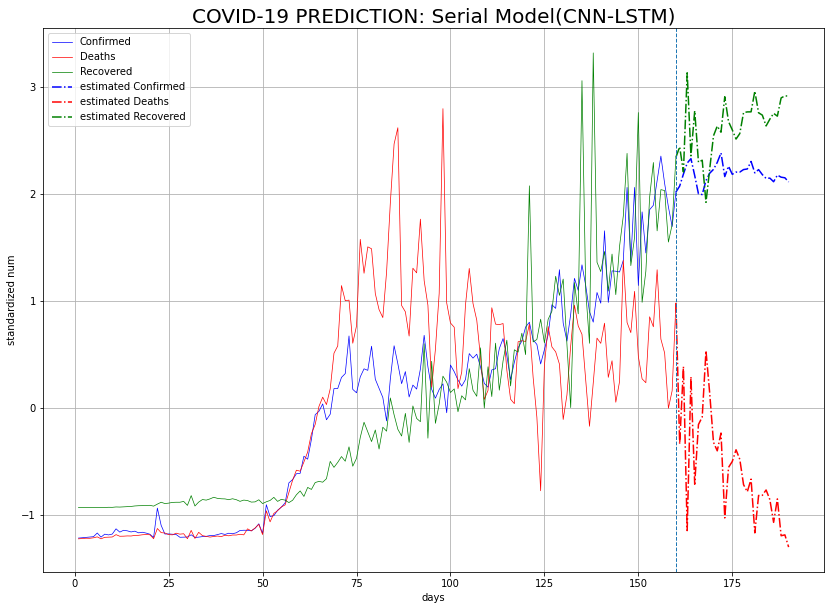

In [29]:
# 데이터 시각화
last_data = X_test_s2[:len(train_data)]
estimated_data = np.array(X_estimates_s2)

ax1 = np.arange(1, len(train_data)+1)
ax2 = np.arange(len(train_data), len(last_data)+len(estimated_data))

plt.figure(figsize=(14, 10))
plt.plot(ax1, last_data[:, 0], label='Confirmed', linewidth=0.7, color='blue')
plt.plot(ax1, last_data[:, 1], label='Deaths', linewidth=0.7, color='red')
plt.plot(ax1, last_data[:, 2], label='Recovered', linewidth=0.7, color='green')
plt.plot(ax2, estimated_data[:, 0], label='estimated Confirmed', linestyle='dashdot', color='blue')
plt.plot(ax2, estimated_data[:, 1], label='estimated Deaths', linestyle='dashdot', color='red')
plt.plot(ax2, estimated_data[:, 2], label='estimated Recovered', linestyle='dashdot', color='green')

plt.axvline(ax1[-1], linestyle='dashed', linewidth=1)

plt.grid()
plt.legend()
plt.xlabel('days')
plt.ylabel('standardized num')
plt.title('COVID-19 PREDICTION: Serial Model(CNN-LSTM)', size=20)

plt.show()